In [2]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2025-09-24 20:34:50.061498: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-24 20:34:50.129529: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-24 20:34:53.142988: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


2.20.0


In [4]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-zkpntwd5
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-zkpntwd5
  Resolved https://github.com/tensorflow/docs to commit e21d085d5ed82504ffcec11aa82ebc78f1f2302e
  Preparing metadata (setup.py) ... done


In [5]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [6]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [8]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz')

2816401408/Unknown 931s 0us/step

In [9]:
FEATURES = 28

In [10]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

2025-09-24 21:59:41.100851: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [11]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

In [12]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


2025-09-24 22:00:09.719077: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


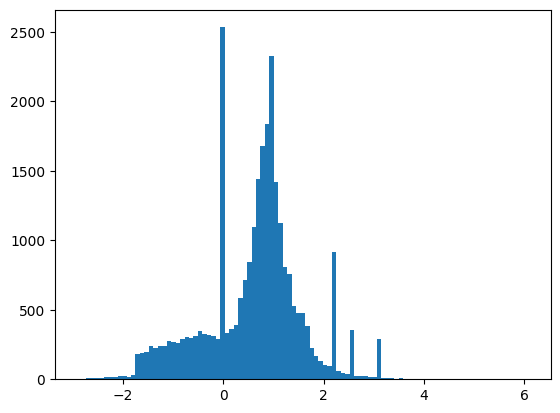

In [13]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

In [14]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [15]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [16]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [17]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [18]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

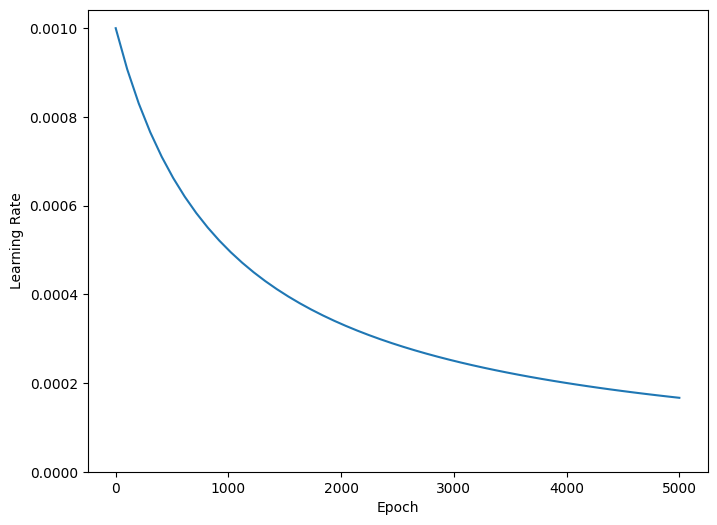

In [19]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [20]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [21]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

In [22]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

/home/heron/Documentos/dl-2025-1/env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
size_histories = {}

In [24]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.4913,  binary_crossentropy:0.8017,  loss:0.8017,  val_accuracy:0.5030,  val_binary_crossentropy:0.5028,  val_loss:0.7541,  
...

2025-09-24 22:01:39.760450: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/heron/Documentos/dl-2025-1/env/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-09-24 22:01:39.927557: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


......

2025-09-24 22:01:40.214774: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


.........

2025-09-24 22:01:40.812947: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


...............

2025-09-24 22:01:41.939903: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


.................................

2025-09-24 22:01:44.239783: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


..................................
Epoch: 100, accuracy:0.6029,  binary_crossentropy:0.6261,  loss:0.6261,  val_accuracy:0.5750,  val_binary_crossentropy:0.4142,  val_loss:0.6214,  
..............................

2025-09-24 22:01:49.150939: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


......................................................................
Epoch: 200, accuracy:0.6200,  binary_crossentropy:0.6155,  loss:0.6155,  val_accuracy:0.5900,  val_binary_crossentropy:0.4074,  val_loss:0.6111,  
..........................................................

2025-09-24 22:01:57.018887: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


..........................................
Epoch: 300, accuracy:0.6311,  binary_crossentropy:0.6089,  loss:0.6089,  val_accuracy:0.6150,  val_binary_crossentropy:0.4048,  val_loss:0.6072,  
....................................................................................................
Epoch: 400, accuracy:0.6416,  binary_crossentropy:0.6033,  loss:0.6033,  val_accuracy:0.6350,  val_binary_crossentropy:0.4020,  val_loss:0.6030,  
....................................................................................................
Epoch: 500, accuracy:0.6495,  binary_crossentropy:0.5989,  loss:0.5989,  val_accuracy:0.6340,  val_binary_crossentropy:0.3999,  val_loss:0.5999,  
..............

2025-09-24 22:02:12.695145: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


......................................................................................
Epoch: 600, accuracy:0.6603,  binary_crossentropy:0.5947,  loss:0.5947,  val_accuracy:0.6390,  val_binary_crossentropy:0.3981,  val_loss:0.5971,  
....................................................................................................
Epoch: 700, accuracy:0.6650,  binary_crossentropy:0.5912,  loss:0.5912,  val_accuracy:0.6420,  val_binary_crossentropy:0.3967,  val_loss:0.5950,  
....................................................................................................
Epoch: 800, accuracy:0.6620,  binary_crossentropy:0.5879,  loss:0.5879,  val_accuracy:0.6570,  val_binary_crossentropy:0.3942,  val_loss:0.5912,  
....................................................................................................
Epoch: 900, accuracy:0.6670,  binary_crossentropy:0.5859,  loss:0.5859,  val_accuracy:0.6480,  val_binary_crossentropy:0.3941,  val_loss:0.5912,  
......................

2025-09-24 22:02:44.772524: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


..........................................................................
Epoch: 1100, accuracy:0.6696,  binary_crossentropy:0.5821,  loss:0.5821,  val_accuracy:0.6610,  val_binary_crossentropy:0.3925,  val_loss:0.5888,  
....................................................................................................
Epoch: 1200, accuracy:0.6750,  binary_crossentropy:0.5809,  loss:0.5809,  val_accuracy:0.6430,  val_binary_crossentropy:0.3943,  val_loss:0.5915,  
....................................................................................................
Epoch: 1300, accuracy:0.6706,  binary_crossentropy:0.5792,  loss:0.5792,  val_accuracy:0.6730,  val_binary_crossentropy:0.3910,  val_loss:0.5866,  
....................................................................................................
Epoch: 1400, accuracy:0.6709,  binary_crossentropy:0.5773,  loss:0.5773,  val_accuracy:0.6760,  val_binary_crossentropy:0.3912,  val_loss:0.5867,  
..............................

(0.5, 0.7)

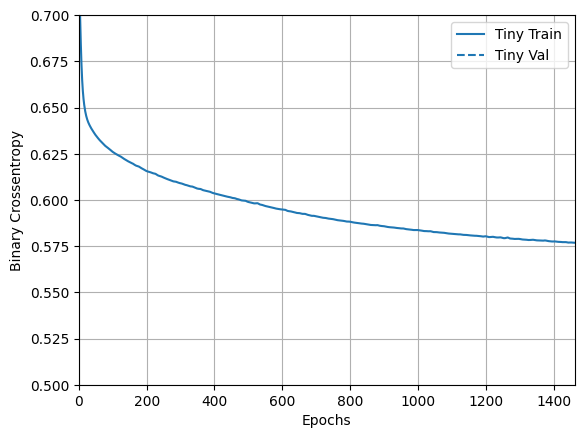

In [25]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])